In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import h5py
from keras import regularizers
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils import normalize
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
%matplotlib inline
#Git changes test

Using TensorFlow backend.


In [2]:
batch_size = 10
num_classes = 1
epochs = 65
channels = 2

In [3]:
#image input dimensions
img_x, img_y = 75,75

In [4]:
#load train  data
train = pd.read_json('./TrainData/data/processed/train.json')
bands = ['band_1','band_2']
x_total = np.empty([1604,0])
for band in bands:
    x_temp = np.zeros((1604,5625))
    for x in range(1604):
        x_temp[x] += train[band][x]
    #x_temp = keras.utils.normalize(x_temp)
    x_total = np.concatenate((x_total,x_temp),axis=1)
y_total = np.array(train['is_iceberg']) 
y_total = y_total.reshape(1604,1)
x_train = x_total
y_train = y_total

In [5]:
#Splitting into test data
#x_train, x_test =x_total[:1444,:], x_total[1444:,:]
#y_train, y_test =y_total[:1444,:], y_total[1444:,:]

In [6]:
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# two channels
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, channels)
#x_test = x_test.reshape(x_test.shape[0], img_x, img_y, channels)
input_shape = (img_x, img_y, channels)

In [7]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2)))
model.add(Dropout(0.2))
          
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
             
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
          
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
          
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.0001)

history = keras.callbacks.History()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [8]:
def getBestModel():
    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])
    best_weights_filepath = './best_weights.hdf5'
    earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='auto')
    saveBestModel = keras.callbacks.ModelCheckpoint(best_weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    # train model
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
              verbose=1)#,# validation_split= 0.10 % callbacks=[earlyStopping, saveBestModel])

    #reload best weights
    model.load_weights(best_weights_filepath)
    return model, history

In [9]:
model,history = getBestModel()

Epoch 1/65
1604/1604 [==============================] - 22s 14ms/step - loss: 0.8197 - acc: 0.4882
Epoch 2/65
1604/1604 [==============================] - 21s 13ms/step - loss: 0.7067 - acc: 0.5212
Epoch 3/65
1604/1604 [==============================] - 21s 13ms/step - loss: 0.6981 - acc: 0.5162
Epoch 4/65
1604/1604 [==============================] - 21s 13ms/step - loss: 0.6945 - acc: 0.5112
Epoch 5/65
1604/1604 [==============================] - 21s 13ms/step - loss: 0.6141 - acc: 0.5823
Epoch 6/65
1604/1604 [==============================] - 21s 13ms/step - loss: 0.5822 - acc: 0.6515
Epoch 7/65
1604/1604 [==============================] - 21s 13ms/step - loss: 0.5810 - acc: 0.6322
Epoch 8/65
1604/1604 [==============================] - 21s 13ms/step - loss: 0.5683 - acc: 0.6577
Epoch 9/65
1604/1604 [==============================] - 21s 13ms/step - loss: 0.5667 - acc: 0.6521
Epoch 10/65
1604/1604 [==============================] - 21s 13ms/step - loss: 0.5594 - acc: 0.6652
Epoch 11/

Test loss: 0.177232580292
Test accuracy: 0.920199501247


KeyError: 'val_acc'

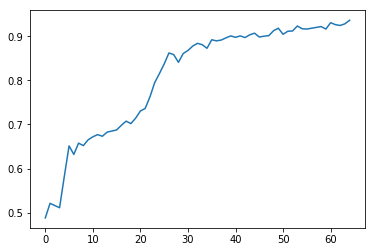

In [10]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'val_loss'

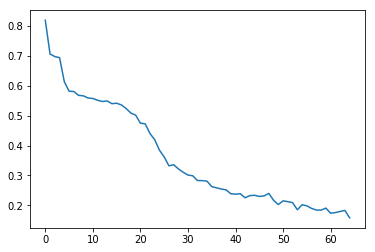

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
hist = history.history['val_loss']
print(sum(hist)/len(hist))

In [15]:
test = pd.read_json('./TestData/processed/test.json')

In [17]:
bands = ['band_1','band_2']
x_test = np.empty([8424,0])
for band in bands:
    x_temp = np.zeros((8424,5625))
    for x in range(8424):
        x_temp[x] += test[band][x]
    x_test = np.concatenate((x_test,x_temp),axis=1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, channels)    

In [18]:
predictions = model.predict(x_test)

In [19]:
#Setting ids as PassengerId and predicting survival
ids = test['id']

df1 = pd.DataFrame(predictions)
df2 = pd.DataFrame(ids)
result = pd.concat([df1, df2], axis=1, join_axes=[df1.index])
result.columns = ['is_iceberg', 'id']
result=result.reindex(columns=['id','is_iceberg'])
result.to_csv('12thSubmissionB.csv', index=False)

In [ ]:
np.unique(predictions)